In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions.constraints as constraints
import pyro 
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC,NUTS #MCMCで利用します
from pyro.optim import Adam #変分推論に利用します
from pyro.infer import SVI, Trace_ELBO #変分推論に利用します
from pyro.infer import Predictive # 予測分布の計算に利用します

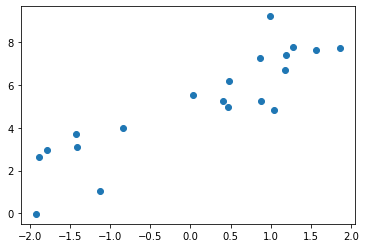

In [2]:
x = np.random.uniform(-2,2,20)
y = 2*x + 5 + np.random.normal(0,1,20)
plt.scatter(x,y)

In [3]:
x_tensor = torch.tensor(x)
y_tensor = torch.tensor(y)

In [4]:
def model(x,y):
    a = pyro.sample('a', dist.Normal(0., 5.))
    b = pyro.sample('b', dist.Normal(0.,5.))
    y = pyro.sample('y', dist.Normal(a*x + b, 1.), obs=y)
    return y

In [5]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc_run.run(x_tensor,y_tensor)

Sample: 100%|██████████████████████████████████████| 2000/2000 [00:10, 189.79it/s, step size=7.43e-01, acc. prob=0.942]


In [6]:
posterior_a = mcmc_run.get_samples()['a']
posterior_b = mcmc_run.get_samples()['b']

In [7]:
pred = Predictive(model,{'a':posterior_a,'b':posterior_b},return_sites=["y"])

In [8]:
x_ = np.linspace(-2,2,100)
y_ = pred.get_samples(torch.tensor(x_),None)['y']

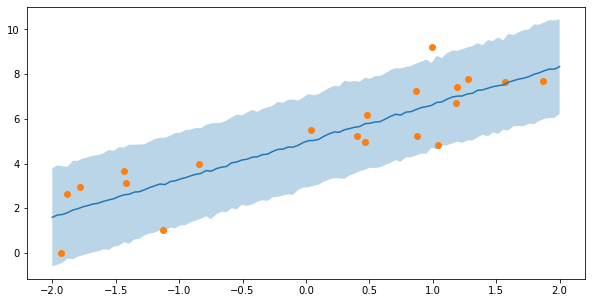

In [9]:
y_mean = y_.mean(0)
y_std = y_.std(0)
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(x,y)

In [10]:
def guide(x,y):
    a_loc = pyro.param('a_loc',torch.tensor(0.))
    b_loc = pyro.param('b_loc',torch.tensor(0.))
    a_scale = pyro.param('a_scale',torch.tensor(1.),constraints.positive)
    b_scale = pyro.param('b_scale',torch.tensor(1.),constraints.positive)
    pyro.sample('a',dist.Normal(a_loc,a_scale))
    pyro.sample('b',dist.Normal(b_loc,b_scale))

In [22]:
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
# do gradient steps
for step in range(n_steps):
    svi.step(x_tensor,y_tensor)

In [23]:
for name in pyro.get_param_store():
    print(name + ':{}'.format(pyro.param(name)))

a_loc:1.7065598964691162
b_loc:4.273370265960693
a_scale:0.2097466140985489
b_scale:0.4267488420009613


In [24]:
y_pred = Predictive(model=model,guide=guide,num_samples=1000,return_sites=["y"])

In [25]:
x_ = torch.tensor(np.linspace(-2,2,100))
y_ = y_pred.get_samples(x_,None)

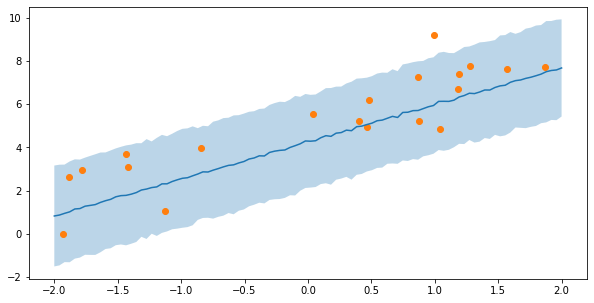

In [26]:
y_mean = y_['y'].mean(0).detach()
y_std = y_['y'].std(0).detach()
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(x,y)

In [76]:

mu_CTT = 100
sigma_CTT = 5
ratio_Int_CTT = 0.2




mu_ITT = 50
sigma_ITT = 5
ratio_Int_ITT = 0.5

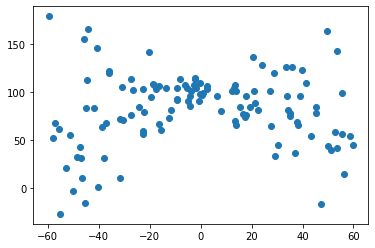

In [114]:
x = np.random.uniform(-60, 60,120)
y = np.cos(np.deg2rad(x)) * np.random.normal(mu_CTT,sigma_CTT,len(x)) + np.random.normal(0, abs(x), len(x))
plt.scatter(x,y)

In [115]:
x_tensor = torch.tensor(x)
y_tensor = torch.tensor(y)

In [116]:
def model(x,y):
    a = pyro.sample('a', dist.Normal(100., 50.))
    b = pyro.sample('b', dist.Normal(0.,5.))
    c = pyro.sample('c', dist.Normal(0.,5.))
    y = pyro.sample('y', dist.Normal(a*np.cos(np.deg2rad(x)), b*abs(x)+c), obs=y)
    return y

In [117]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc_run.run(x_tensor,y_tensor)

Sample: 100%|███████████████████████████████████████| 2000/2000 [00:21, 94.47it/s, step size=7.96e-01, acc. prob=0.835]


In [118]:
posterior_a = mcmc_run.get_samples()['a']
posterior_b = mcmc_run.get_samples()['b']
posterior_c = mcmc_run.get_samples()['c']

In [119]:
pred = Predictive(model,{'a':posterior_a,'b':posterior_b,'c':posterior_c},return_sites=["y"])

In [120]:
x_ = np.linspace(-60,60,120)
y_ = pred.get_samples(torch.tensor(x_),None)['y']

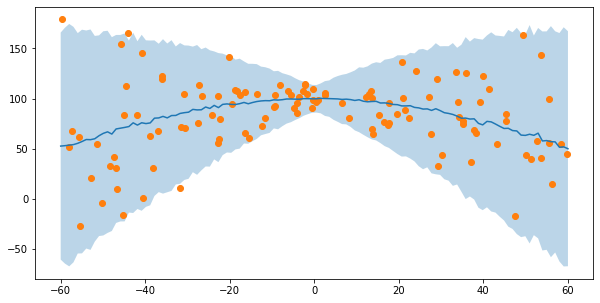

In [121]:
y_mean = y_.mean(0)
y_std = y_.std(0)
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(x,y)